In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
import dataframe_image as dfi # for saving styled data frame print-out table as png
from duneanalytics import DuneAnalytics 

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 3.5)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py

## Input

In [4]:
chain = 'Avalanche'

In [5]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Fees'):
        fnames['Fees'] = fname
fnames

{'Fees': 'Fees_2022-01-06_2022-07-25.csv'}

In [6]:
# get Dune Analytics login credentials
MY_USERNAME = os.environ.get('DUNE_USERNAME')
MY_PASSWORD = os.environ.get('DUNE_PASSWORD')
dune = DuneAnalytics(MY_USERNAME, MY_PASSWORD)

## Read Fees Data from Stats.GMX

In [7]:
# only read the first 7 cols since the last col "Cumulative" is NOT the daily total, but cumulative daily total, 
# which we don't want.
df_fees = pd.read_csv(os.path.join(data_dir, chain, fnames['Fees']), 
                      parse_dates=['Date'], index_col='Date', usecols=range(6))
df_fees.columns = df_fees.columns.str.lower().str.replace(' ', '_') + '_fees'
# calc daily total 
df_fees['total_fees'] = df_fees.sum(axis=1)
df_fees.head()

,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,total_fees
Date,,,,,,
2022-01-06,243.7315,"1,841.6199","46,512.0344",61.2569,0.1118,"48,658.7544"
2022-01-07,"8,361.3507","8,681.5863","5,877.2475","1,085.8670","1,456.0469","25,462.0984"
2022-01-08,"12,425.6089","12,073.8660","3,506.1064",957.7285,422.3647,"29,385.6744"
2022-01-09,"13,572.4639","79,978.1430","4,695.0731",181.7615,0.6246,"98,428.0661"
2022-01-10,"23,276.3600","128,402.3029","4,230.0247",242.7791,425.5660,"156,577.0327"


## Read Fees Data from Dune

In [8]:
dune.login()
dune.fetch_auth_token()
 
# fetch query result
result_id = dune.query_result_id(query_id=1101719)
data = dune.query_result(result_id)

# extract the relavent data fields
dd = data['data']['get_result_by_result_id']
df = pd.json_normalize(dd, record_prefix='')
df = df.loc[:, df.columns.str.startswith('data')]
df.columns = df.columns.str.replace('data.', '', regex=False)
df

,day,revenue
0,2021-12-22T00:00:00Z,3.9574
1,2021-12-27T00:00:00Z,0.2860
2,2021-12-30T00:00:00Z,2.3877
3,2022-01-02T00:00:00Z,1.1577
4,2022-01-03T00:00:00Z,9.1934
...,...,...
203,2022-07-21T00:00:00Z,"95,922.4970"
204,2022-07-22T00:00:00Z,"89,952.4972"
205,2022-07-23T00:00:00Z,"30,693.8698"
206,2022-07-24T00:00:00Z,"33,606.2743"


In [9]:
df['date'] = pd.to_datetime(df.day.str.replace('T.*', '', regex=True))
del df['day']
df = df.set_index('date')
df.head()

,revenue
date,
2021-12-22,3.9574
2021-12-27,0.2860
2021-12-30,2.3877
2022-01-02,1.1577
2022-01-03,9.1934


## Compare

In [10]:
dat = pd.merge(df_fees, df, left_index=True, right_index=True)

# drop the last row because the most recent date may not be a full day
# drop the first row because it's the first day and public hasn't started using the platform yet
dat = dat.iloc[1:-1, :]
dat

,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,total_fees,revenue
2022-01-07,"8,361.3507","8,681.5863","5,877.2475","1,085.8670","1,456.0469","25,462.0984","25,477.1051"
2022-01-08,"12,425.6089","12,073.8660","3,506.1064",957.7285,422.3647,"29,385.6744","29,382.3590"
2022-01-09,"13,572.4639","79,978.1430","4,695.0731",181.7615,0.6246,"98,428.0661","98,444.4291"
2022-01-10,"23,276.3600","128,402.3029","4,230.0247",242.7791,425.5660,"156,577.0327","156,592.7057"
2022-01-11,"12,251.6583","111,592.4128","13,408.3932",318.0126,0.9354,"137,571.4123","137,617.4315"
...,...,...,...,...,...,...,...
2022-07-20,"15,205.8305","74,798.1138",692.8198,"38,343.9950",110.8641,"129,151.6231","129,132.6786"
2022-07-21,"18,604.4428","75,926.8368",609.7231,525.1870,270.1154,"95,936.3051","95,922.4970"
2022-07-22,"13,373.6354","63,141.8128","1,242.3702","12,129.5697",70.9317,"89,958.3199","89,952.4972"
2022-07-23,"3,340.5501","25,542.6579",386.0792,"1,410.3069",17.1037,"30,696.6976","30,693.8698"


In [11]:
# a = dat.swap_fees+dat.mint_glp_fees+dat.burn_glp_fees
# a = dat.margin_trading_fees + dat.liquidation_fees
a = dat.total_fees
b = dat.revenue
res = a - b
res

2022-01-07   -15.0067
2022-01-08     3.3154
2022-01-09   -16.3630
2022-01-10   -15.6730
2022-01-11   -46.0192
               ...   
2022-07-20    18.9445
2022-07-21    13.8082
2022-07-22     5.8227
2022-07-23     2.8279
2022-07-24     0.7525
Length: 199, dtype: float64

In [12]:
print(res.min(), res.max())

-259.63788879243657 469.63358924369095


In [13]:
print(res.mean())

3.59740634395423


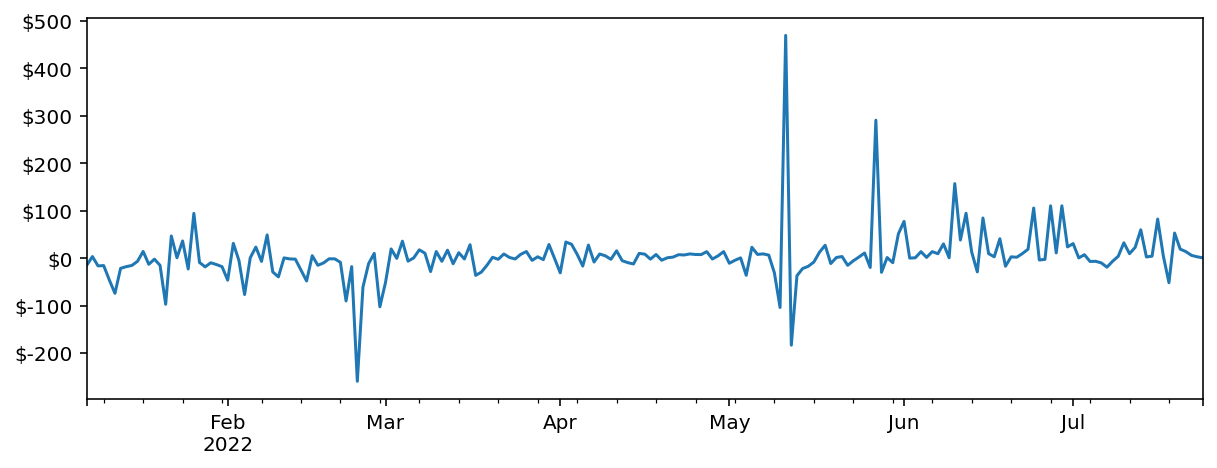

In [14]:
ax = res.plot()
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)

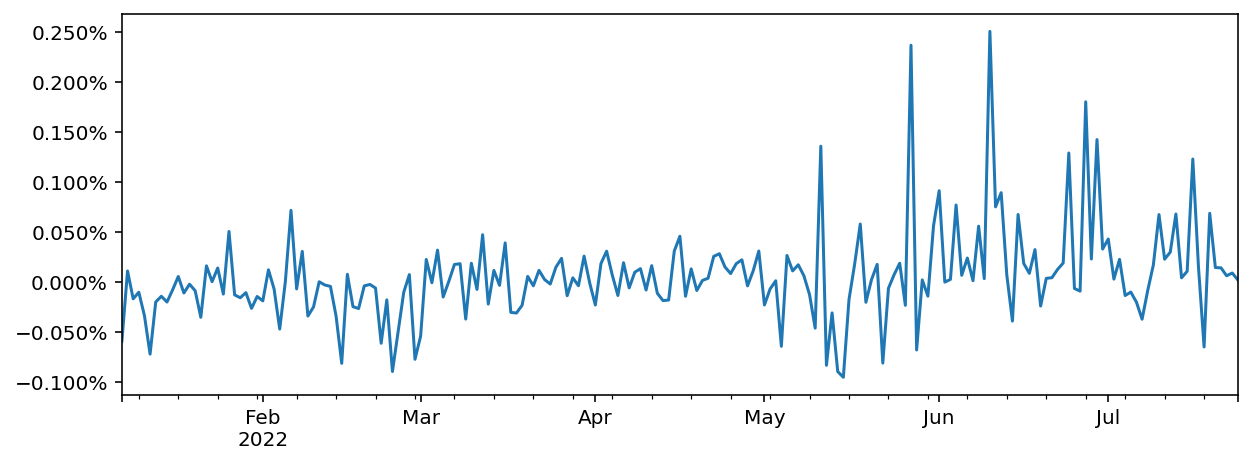

In [15]:
base = (a + b)/2
pct_diff = res / base # should be very small
ax = pct_diff.plot()
ax.yaxis.set_major_formatter(PercentFormatter(1))